In [1]:
### Ref: https://github.com/ageron/handson-ml2/blob/master/14_deep_computer_vision_with_cnns.ipynb


# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
import pandas as pd

# to make this notebook's output stable across runs
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# For basic Image IO
import IPython.display as display
from PIL import Image

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)


def make_dirs(path, clean=False):
    if not os.path.exists(path):
        os.makedirs(path)
    else: #Empty the directory
        if clean == True:
            shutil.rmtree(path)
    return
    

#Add basic logging
import logging     
make_dirs("logs/events")
logging.basicConfig(filename=os.path.join("logs/events",'cs230_keras_notebook.log'),
                    level=logging.DEBUG,
                   format='%(asctime)s %(message)s', 
                    datefmt='%m/%d/%Y %I:%M:%S %p')

#Load Extensions
%load_ext tensorboard
tensorboard_dir = "logs/tensorboard"
make_dirs(tensorboard_dir)
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(tensorboard_dir, run_id)
run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [2]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [5]:
def show_batch(image_batch, label_batch, class_indices):
    print("image_batch_shape {}".format(image_batch.shape))
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        label_indices = np.argmax(label_batch[n])
        
        #Flip the dictionary from class_indices to indices_class
        indices_class = dict((v,k) for k, v in class_indices.items()) 
        plt.imshow(image_batch[n])
        plt.title(label_batch[n])
        plt.title(indices_class.get(label_indices))
        plt.axis('off')

In [6]:
def show_batch_grayscale(image_batch, label_batch):
    print("image_batch_shape {}".format(image_batch.shape))
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(np.squeeze(image_batch[n]), cmap='gray',interpolation='none')
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

In [7]:
#This assumed that you have checked out the data repo next to the object detection repo
# Data repo can be found over here: https://github.com/nandini-sundar/CS230-TrashNet-YOLO-Labeled
import pathlib
data_dir = pathlib.Path("../CS230-TrashNet-YOLO-Labeled")

In [8]:
class_names_file = data_dir.joinpath("classes.txt")
class_names = pd.read_csv(class_names_file, header = None, sep='\n', names=['classes'])
print(class_names.values)
n_classes = len(class_names)
print(n_classes)

[['glass']
 ['metal']
 ['plastic']
 ['cardboard']
 ['trash']
 ['paper']]
6


In [9]:
import shutil

data_images_dir = data_dir.joinpath("Images")
CLASS_NAMES = np.array([item.name for item in data_images_dir.glob('*') if item.name != "LICENSE.txt"])

CLASS_NAMES

#Make directory to save generated images
generated_train_images_dir = data_dir.joinpath("generated/train")
generated_validation_images_dir = data_dir.joinpath("generated/validation")
generated_test_images_dir = data_dir.joinpath("generated/test")
if not os.path.exists(generated_train_images_dir):
    os.makedirs(generated_train_images_dir)
    os.makedirs(generated_validation_images_dir)
    os.makedirs(generated_test_images_dir)
else: #Empty the directory
    shutil.rmtree(generated_train_images_dir)
    shutil.rmtree(generated_validation_images_dir)
    shutil.rmtree(generated_test_images_dir)
    
    os.makedirs(generated_train_images_dir)
    os.makedirs(generated_validation_images_dir)
    os.makedirs(generated_test_images_dir)
    
logging.info("Generated train images stored at {}".format(generated_train_images_dir))
logging.info("Generated validation images stored at {}".format(generated_validation_images_dir))
logging.info("Generated test images stored at {}".format(generated_test_images_dir))

In [10]:
image_count = len(list(data_images_dir.glob('*/*.jpg')))
print("Total number of input images {}".format(image_count))

Total number of input images 2527


In [11]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [12]:
def get_dataframe_for_generator(filename, x_col, y_col):
    df = pd.read_csv(data_dir.joinpath(filename), names=[x_col])
    
    #Convert foldernames in filepaths to class names.
    #Expects filepath in format : ./Images/paper/paper283.jpg
    df[y_col] = df[x_col].apply(lambda x: os.path.basename(os.path.dirname(x)))
    
    return df
    
x_col = "filename"
y_col = 'class_list'

train_df = get_dataframe_for_generator(filename='train.txt', x_col=x_col, y_col=y_col)
logging.debug("Here are some train images ")
logging.debug(train_df)

test_df = get_dataframe_for_generator(filename='test.txt', x_col=x_col, y_col=y_col)
logging.debug("Here are some test images ")
logging.debug(test_df)

In [13]:
def split_and_join(s, repl):
    splits = str.split(s, '/')
    splits[1] = repl
    return "/".join(splits)

In [14]:
train_df['label_path']  = train_df[x_col].str.replace(pat='.jpg', repl='.txt')
train_df['label_path'] = train_df['label_path'].apply(lambda x: split_and_join(x, 'Labels'))

In [15]:
train_df

,filename,class_list,label_path
0,./Images/paper/paper283.jpg,paper,./Labels/paper/paper283.txt
1,./Images/paper/paper297.jpg,paper,./Labels/paper/paper297.txt
2,./Images/paper/paper526.jpg,paper,./Labels/paper/paper526.txt
3,./Images/paper/paper240.jpg,paper,./Labels/paper/paper240.txt
4,./Images/paper/paper254.jpg,paper,./Labels/paper/paper254.txt
...,...,...,...
2270,./Images/plastic/plastic405.jpg,plastic,./Labels/plastic/plastic405.txt
2271,./Images/plastic/plastic411.jpg,plastic,./Labels/plastic/plastic411.txt
2272,./Images/plastic/plastic377.jpg,plastic,./Labels/plastic/plastic377.txt
2273,./Images/plastic/plastic439.jpg,plastic,./Labels/plastic/plastic439.txt


In [16]:
#train_df['label_path'].apply(lambda label_path : pd.read_csv(data_dir.joinpath(label_path) ))
label_format = ['class_id', 'x', 'y', 'w', 'h']

labels_list = []
for label_file in train_df['label_path']:
    label_file = data_dir.joinpath(label_file)
    df_label_indiv = pd.read_csv(label_file, sep=" ", names=label_format)
    
    #Keeping only first row of the dataframe for simplicity
    df_label_indiv = df_label_indiv.head(1)
    labels_list.append(df_label_indiv)

df_label_all = pd.concat(labels_list)
df_label_all.reset_index(drop=True, inplace=True)
#print(df_label_all)

df_label_all.index = train_df.index
train_df_x_y = pd.concat([train_df, df_label_all], axis=1, sort=False)
train_df_x_y

,filename,class_list,label_path,class_id,x,y,w,h
0,./Images/paper/paper283.jpg,paper,./Labels/paper/paper283.txt,5,0.503906,0.519531,0.992188,0.966146
1,./Images/paper/paper297.jpg,paper,./Labels/paper/paper297.txt,5,0.467773,0.503906,0.916016,0.986979
2,./Images/paper/paper526.jpg,paper,./Labels/paper/paper526.txt,5,0.453125,0.503906,0.890625,0.981771
3,./Images/paper/paper240.jpg,paper,./Labels/paper/paper240.txt,5,0.393555,0.585938,0.775391,0.828125
4,./Images/paper/paper254.jpg,paper,./Labels/paper/paper254.txt,5,0.550781,0.503906,0.894531,0.955729
...,...,...,...,...,...,...,...,...
2270,./Images/plastic/plastic405.jpg,plastic,./Labels/plastic/plastic405.txt,2,0.501953,0.505208,0.988281,0.989583
2271,./Images/plastic/plastic411.jpg,plastic,./Labels/plastic/plastic411.txt,2,0.689453,0.613281,0.617188,0.648438
2272,./Images/plastic/plastic377.jpg,plastic,./Labels/plastic/plastic377.txt,2,0.490234,0.404948,0.523438,0.695312
2273,./Images/plastic/plastic439.jpg,plastic,./Labels/plastic/plastic439.txt,2,0.588867,0.605469,0.365234,0.789062


In [17]:
def deconvert(yolobox, img_width,img_height ):
    
    ox = float(yolobox[0])
    oy = float(yolobox[1])
    ow = float(yolobox[2])
    oh = float(yolobox[3])
    x = ox*img_width
    y = oy*img_height
    w = ow*img_width
    h = oh*img_height
    xmax = (((2*x)+w)/2)
    xmin = xmax-w
    ymax = (((2*y)+h)/2)
    ymin = ymax-h
    print(xmin, ymin, xmax, ymax)
    return int(xmin),int(xmax),int(ymin),int(ymax)

In [18]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                 validation_split=0.25,
                                                                 rotation_range=180,
                                                                 shear_range=0.5,
                                                                  zoom_range=0.9,
                                                                  horizontal_flip=True,
                                                                 vertical_flip=True,
                                                                  width_shift_range=0.1,
                                                                height_shift_range=0.1,
                                                                 fill_mode='nearest')

train_generator = image_generator.flow_from_dataframe(dataframe=train_df_x_y,
                                                     directory=data_dir,
                                                     x_col=x_col,
                                                     y_col="class_list",
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     seed=SEED,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='categorical',
                                                    save_to_dir=generated_train_images_dir,
                                                     subset="training",
                                                      subdirectories=True,
                                                    save_prefix="gen-")

Found 1707 validated image filenames belonging to 6 classes.


In [19]:
validation_data_gen = image_generator.flow_from_dataframe(dataframe=train_df_x_y,
                                                     directory=data_dir,
                                                     x_col=x_col,
                                                     y_col="class_list",
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                    seed=SEED,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='categorical',
                                                    save_to_dir=generated_validation_images_dir,
                                                     subset="validation",
                                                    save_prefix="gen-")

Found 568 validated image filenames belonging to 6 classes.


In [34]:
test_df

,filename,class_list
0,./Images/paper/paper70.jpg,paper
1,./Images/paper/paper123.jpg,paper
2,./Images/paper/paper65.jpg,paper
3,./Images/paper/paper280.jpg,paper
4,./Images/paper/paper445.jpg,paper
...,...,...
247,./Images/plastic/plastic214.jpg,plastic
248,./Images/plastic/plastic189.jpg,plastic
249,./Images/plastic/plastic362.jpg,plastic
250,./Images/plastic/plastic202.jpg,plastic


In [51]:
#Notice that y_col = None
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_data_gen = test_generator.flow_from_dataframe(dataframe=test_df,
                                                     directory=data_dir,
                                                     x_col=x_col,
                                                     y_col="class_list",
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                    seed=SEED,
                                                   class_mode='categorical', 
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    save_to_dir=generated_test_images_dir,
                                                    save_prefix="gen-")

Found 252 validated image filenames belonging to 6 classes.


In [53]:
image_batch, label_batch = next(train_da)
image_batch.shape

(32, 224, 224, 3)

In [54]:
len(label_batch)

32

image_batch_shape (32, 224, 224, 3)


/home/hnkulkarni/envs/cs230/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


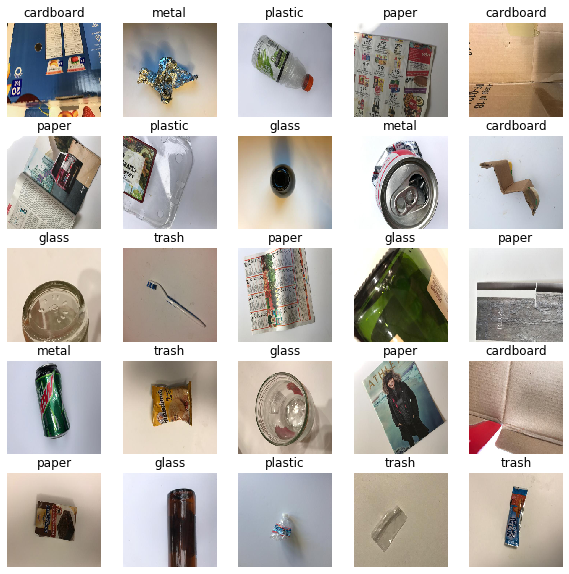

In [55]:
show_batch(image_batch, label_batch, train_generator.class_indices)

In [59]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("cs230_keras_trashnet_classification.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)
reduce_lr_cb = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
csv_logger_cb = keras.callbacks.CSVLogger('training.log')


callback_list = [tensorboard_cb,checkpoint_cb,early_stopping_cb,reduce_lr_cb,csv_logger_cb]

In [60]:
base_model = keras.applications.xception.Xception(weights='imagenet',
                                                 include_top = False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input,
                           outputs=[class_output])

In [61]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_3
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_8
13 block2_pool
14 batch_normalization_8
15 add_24
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_9
23 block3_pool
24 batch_normalization_9
25 add_25
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_10
33 block4_pool
34 batch_normalization_10
35 add_26
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_27
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_

In [62]:
for layer in base_model.layers:
    layer.trainable = False
    
adam = tf.keras.optimizers.Adam(lr=0.01) #Higher lerarning rate
model.compile(adam, loss=['categorical_crossentropy'], metrics=['accuracy'])

In [63]:
history = model.fit_generator(train_generator, epochs=2, workers=8, 
                                       steps_per_epoch=train_generator.samples // BATCH_SIZE, 
                                       shuffle=True,
                            validation_data=validation_data_gen,
                             callbacks = callback_list)

Epoch 1/2
53/53 [==============================] - 27s 513ms/step - loss: 1.1223 - accuracy: 0.5564 - val_loss: 15.1759 - val_accuracy: 0.0088
Epoch 2/2
53/53 [==============================] - 28s 521ms/step - loss: 0.9692 - accuracy: 0.6388 - val_loss: 15.0796 - val_accuracy: 0.0370


In [65]:
#Unfreeze the layers from the base model
for layer in base_model.layers:
    layer.trainable = True
    
adam = tf.keras.optimizers.Adam(lr=0.000001) #Lower the lerarning rate lerarning rate
model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit_generator(train_generator, epochs=2, workers=8, 
                                       steps_per_epoch=train_generator.samples // BATCH_SIZE, 
                                       shuffle=True,
                              validation_data=validation_data_gen,
                             callbacks=[tensorboard_cb,checkpoint_cb,reduce_lr_cb,csv_logger_cb])

Epoch 1/20
53/53 [==============================] - 31s 577ms/step - loss: 1.0229 - accuracy: 0.6334 - val_loss: 15.0371 - val_accuracy: 0.0405
Epoch 2/20
53/53 [==============================] - 29s 556ms/step - loss: 0.9794 - accuracy: 0.6472 - val_loss: 15.1013 - val_accuracy: 0.0458
Epoch 3/20
53/53 [==============================] - 29s 555ms/step - loss: 0.9564 - accuracy: 0.6442 - val_loss: 15.0889 - val_accuracy: 0.0493
Epoch 4/20
53/53 [==============================] - 29s 540ms/step - loss: 0.9349 - accuracy: 0.6490 - val_loss: 15.1414 - val_accuracy: 0.0458
Epoch 5/20
53/53 [==============================] - 29s 546ms/step - loss: 0.9387 - accuracy: 0.6651 - val_loss: 15.1049 - val_accuracy: 0.0493
Epoch 6/20
53/53 [==============================] - 29s 543ms/step - loss: 0.8860 - accuracy: 0.6710 - val_loss: 15.0716 - val_accuracy: 0.0440
Epoch 7/20
53/53 [==============================] - 31s 578ms/step - loss: 0.9263 - accuracy: 0.6424 - val_loss: 14.8548 - val_accuracy:

In [66]:
model.evaluate_generator(test_data_gen,test_data_gen.samples//BATCH_SIZE,
                        callbacks=callback_list)

[3.995772191456386, 0.65178573]

In [30]:
train_generator.class_indices

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [31]:
indices_class = dict((v,k) for k, v in train_generator.class_indices.items())

In [32]:
print(indices_class)

{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


image_batch_shape (32, 224, 224, 3)


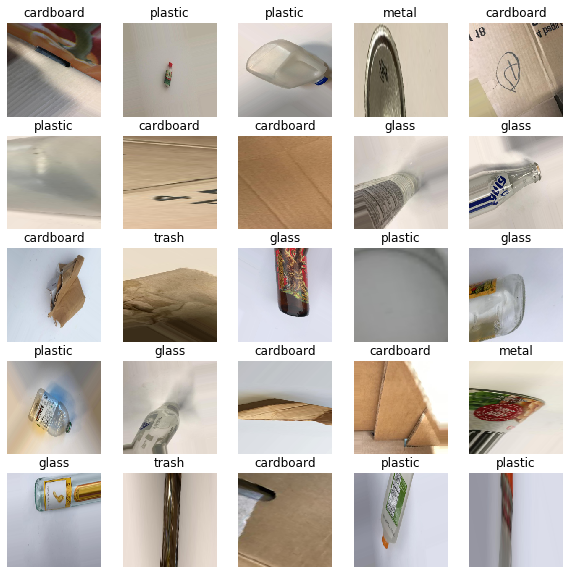

In [33]:
show_batch(image_batch, label_batch, train_generator.class_indices)

In [67]:
from kerastuner.applications import HyperResNet
from kerastuner.tuners import Hyperband

In [72]:
import cv2

def generate_data(df, x_col, dir_path ):
    X_data = []
    for f in df[x_col]:
        f = dir_path.joinpath(f)
        f = str(f)
        img = cv2.imread(f)
        norm_image = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        X_data.append(norm_image)
        
    X_data = np.array(X_data)
    #X_data = X_data / 255
    return X_data
 

X_data = generate_data(df=train_df_x_y, x_col=x_col, dir_path=data_dir )

array([[[[0.86274517, 0.909804  , 0.92549026],
         [0.86274517, 0.909804  , 0.92549026],
         [0.86274517, 0.909804  , 0.92549026],
         ...,
         [0.73333335, 0.79215693, 0.82745105],
         [0.73333335, 0.79215693, 0.82745105],
         [0.73333335, 0.79215693, 0.82745105]],

        [[0.86274517, 0.909804  , 0.92549026],
         [0.86274517, 0.909804  , 0.92549026],
         [0.86274517, 0.909804  , 0.92549026],
         ...,
         [0.73333335, 0.79215693, 0.82745105],
         [0.73333335, 0.79215693, 0.82745105],
         [0.73333335, 0.79215693, 0.82745105]],

        [[0.86274517, 0.909804  , 0.92549026],
         [0.86274517, 0.909804  , 0.92549026],
         [0.86274517, 0.909804  , 0.92549026],
         ...,
         [0.73333335, 0.79215693, 0.82745105],
         [0.73333335, 0.79215693, 0.82745105],
         [0.73333335, 0.79215693, 0.82745105]],

        ...,

        [[0.6117647 , 0.47450984, 0.4901961 ],
         [0.627451  , 0.4901961 , 0.5058824 ]

In [73]:
X_data

array([[[[0.86274517, 0.909804  , 0.92549026],
         [0.86274517, 0.909804  , 0.92549026],
         [0.86274517, 0.909804  , 0.92549026],
         ...,
         [0.73333335, 0.79215693, 0.82745105],
         [0.73333335, 0.79215693, 0.82745105],
         [0.73333335, 0.79215693, 0.82745105]],

        [[0.86274517, 0.909804  , 0.92549026],
         [0.86274517, 0.909804  , 0.92549026],
         [0.86274517, 0.909804  , 0.92549026],
         ...,
         [0.73333335, 0.79215693, 0.82745105],
         [0.73333335, 0.79215693, 0.82745105],
         [0.73333335, 0.79215693, 0.82745105]],

        [[0.86274517, 0.909804  , 0.92549026],
         [0.86274517, 0.909804  , 0.92549026],
         [0.86274517, 0.909804  , 0.92549026],
         ...,
         [0.73333335, 0.79215693, 0.82745105],
         [0.73333335, 0.79215693, 0.82745105],
         [0.73333335, 0.79215693, 0.82745105]],

        ...,

        [[0.6117647 , 0.47450984, 0.4901961 ],
         [0.627451  , 0.4901961 , 0.5058824 ]

In [74]:
## Load output y_class_output
class_output = train_df_x_y[label_format[0]].tolist()
y_class_output = tf.keras.utils.to_categorical(class_output, n_classes )
y_class_output

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

In [78]:
n_classes

6

In [81]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [82]:
X, y = shuffle(X_data, y_class_output)

In [83]:
X.shape

(2275, 384, 512, 3)

In [107]:
def train_validation_test_split(X, y, test_size=0.25, validation_size=0.25):
    import numpy as np
    from sklearn.model_selection import train_test_split
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=validation_size, random_state=42)
    return X_train, X_valid, X_test, y_train, y_valid, y_test
    

In [108]:
import numpy as np
from sklearn.model_selection import train_test_split
X, y = np.arange(30).reshape((15, 2)), range(15)
X

array([[ 0,  1],
       [ 2,  3],
       [ 4,  5],
       [ 6,  7],
       [ 8,  9],
       [10, 11],
       [12, 13],
       [14, 15],
       [16, 17],
       [18, 19],
       [20, 21],
       [22, 23],
       [24, 25],
       [26, 27],
       [28, 29]])

In [109]:
list(y)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [112]:
train_validation_test_split(X, y, test_size=0.25, validation_size=0.25)

(array([[12, 13],
        [ 4,  5],
        [16, 17],
        [24, 25],
        [28, 29],
        [20, 21],
        [ 2,  3],
        [14, 15]]), array([[ 8,  9],
        [10, 11],
        [ 6,  7]]), array([[18, 19],
        [22, 23],
        [ 0,  1],
        [26, 27]]), [6, 2, 8, 12, 14, 10, 1, 7], [4, 5, 3], [9, 11, 0, 13])

In [102]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=SEED)

In [103]:
X_train

array([[ 0,  1],
       [14, 15],
       [ 4,  5],
       [18, 19],
       [ 8,  9],
       [ 6,  7],
       [12, 13]])

In [104]:
y_train

[0, 7, 2, 9, 4, 3, 6]

In [105]:
X_test

array([[16, 17],
       [ 2,  3],
       [10, 11]])

In [106]:
y_test

[8, 1, 5]

In [80]:
hypermodel = HyperResNet(input_shape=(224, 224, 3), num_classes=n_classes)

tuner = Hyperband(
    hypermodel,
    objective='val_accuracy',
    max_epochs=40,
    directory='my_dir',
    project_name='my_trashnet')

tuner.search_(X_data, y_class_output,
             epochs=20,
             validation_data=(val_x, val_y))

TypeError: __init__() got an unexpected keyword argument 'num_classes'